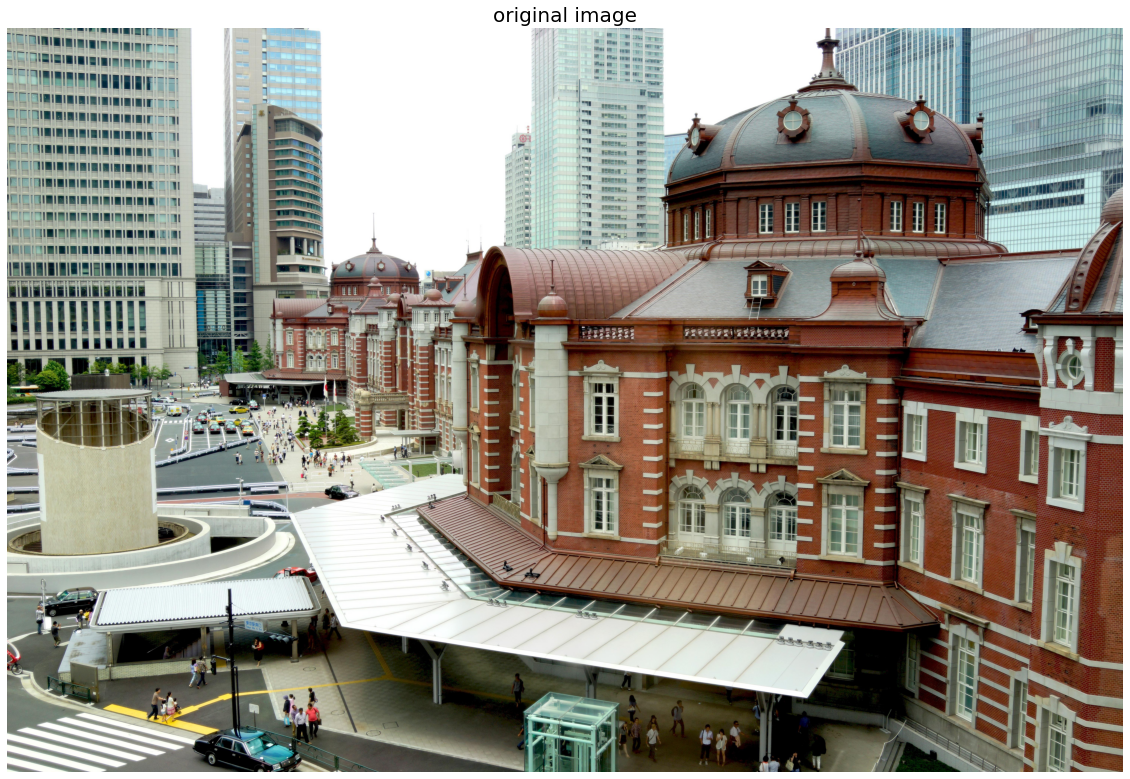

In [1]:
import cv2
import imageio
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
import numpy as np
import matplotlib.pyplot as plt
import torch

# CHANGE THESE TO YOUR SETTINGS
image = np.array(Image.open('images/tokyo-station.jpg'))
img_wh = (6000, 4000)
n_scales = 5
patch_wh = (25, 25)
exp_name = f'tokyo6k_{n_scales}scale_lap' # where the checkpoints are saved
###############################

image = cv2.resize(image, img_wh)
plt.figure(figsize=(20, 20))
plt.axis('off')
plt.title('original image', fontsize=20)
plt.imshow(image);

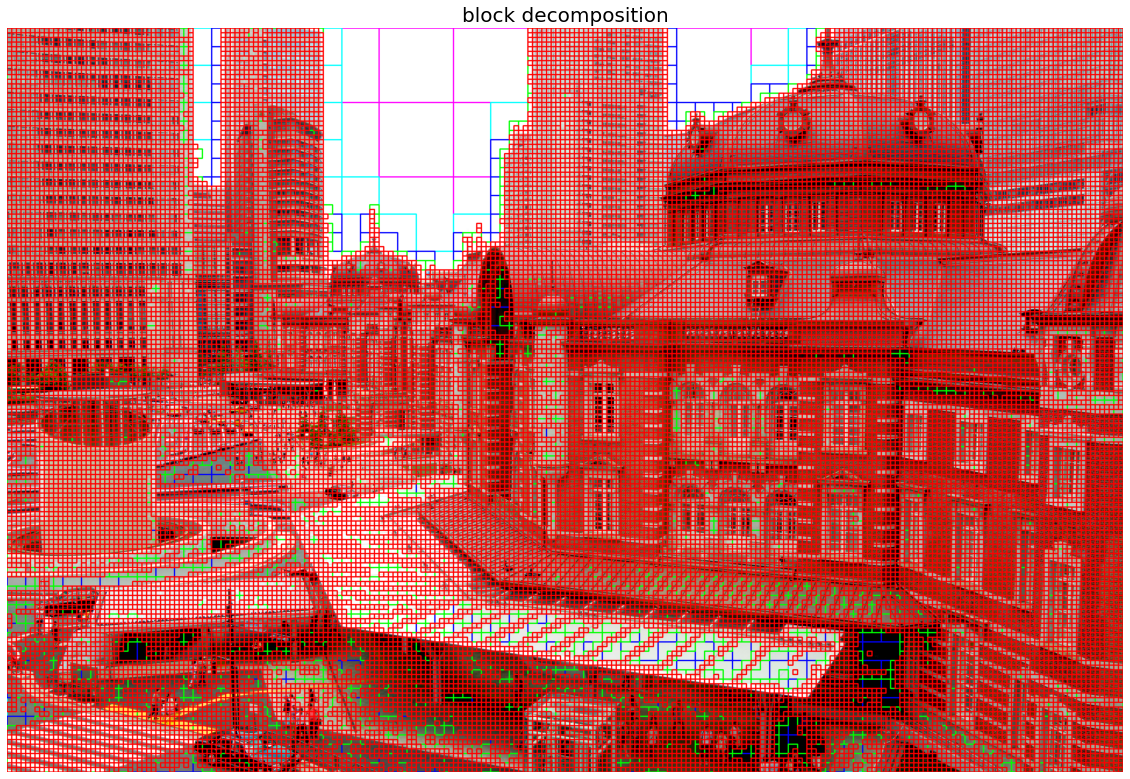

In [2]:
COLORS = [(255, 0, 0), (0, 255, 0), (0, 0, 255),
          (0, 255, 255), (255, 0, 255), (255, 255, 0)] # colors for each scale

image_ = image.copy()
for l in reversed(range(n_scales)):
    rw, rh = patch_wh[0]*2**l, patch_wh[1]*2**l
    ckpt = torch.load(f'ckpts/{exp_name}/l{l}/last.ckpt', map_location=torch.device('cpu'))['state_dict']
    training_blocks = np.ones((image.shape[0]//rh, image.shape[1]//rw), bool)
    active_blocks = ckpt['active_blocks'].numpy().reshape(image.shape[0]//rh, image.shape[1]//rw)
    training_blocks[active_blocks] = 0 # converged

    for row in range(training_blocks.shape[0]):
        for col in range(training_blocks.shape[1]):
            if not training_blocks[row, col]:
                cv2.rectangle(image_, (col*rw, row*rh), ((col+1)*rw, (row+1)*rh), COLORS[l],
                              int(np.ceil(max(image.shape)/1000)))

plt.figure(figsize=(20, 20))
plt.axis('off')
plt.title('block decomposition', fontsize=20)
plt.imshow(image_);

In [4]:
# save decomposition image
imageio.imsave('tokyo6k_5scale_blocks.jpg', image_)